# AML Fraud Detection - Data Exploration and Model Development

This notebook demonstrates the development of an Anti-Money Laundering (AML) fraud detection system using:
- Dynamic thresholds for suspicious activity detection
- Anomaly detection algorithms for outlier identification  
- Clustering analysis for pattern recognition
- Supervised learning for classification
- Historical data analysis for baseline establishment

## Objectives:
1. Load and explore AML datasets (~10k records)
2. Implement anomaly detection, clustering, and supervised learning
3. Develop dynamic thresholds based on user historical data
4. Create a comprehensive outlier detection system

Let's start by importing the required libraries and setting up our environment.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
import xgboost as xgb

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn available")
print(f"XGBoost version: {xgb.__version__}")

Libraries imported successfully!
Pandas version: 2.3.1
NumPy version: 2.3.2
Scikit-learn available
XGBoost version: 3.0.3


## 1. Load and Explore AML Dataset

We'll start by loading an AML dataset. For this demonstration, we'll create a synthetic dataset that mimics real-world AML patterns with approximately 10,000 records.

### Dataset Features:
- **Transaction Information**: Amount, frequency, time patterns
- **Customer Information**: Age, account age, risk scores
- **Behavioral Patterns**: Cross-border transactions, cash transactions, unusual timing
- **Risk Indicators**: Geographic risk, merchant risk, payment method risk

In [2]:
# Generate Synthetic AML Dataset
def generate_aml_dataset(n_samples=10000):
    """Generate synthetic AML dataset with realistic patterns"""
    
    # Set random seed
    np.random.seed(42)
    
    # Generate customer IDs (fewer customers than transactions)
    customer_ids = np.random.randint(1, n_samples // 8, size=n_samples)
    
    # Generate transaction amounts (log-normal distribution)
    base_amounts = np.random.lognormal(mean=6, sigma=2, size=n_samples)
    transaction_amounts = np.clip(base_amounts, 10, 1000000)
    
    # Generate customer demographics
    customer_ages = np.random.normal(45, 15, size=n_samples)
    customer_ages = np.clip(customer_ages, 18, 85)
    
    # Account age in days
    account_ages = np.random.exponential(scale=800, size=n_samples)
    account_ages = np.clip(account_ages, 1, 3650)  # Max 10 years
    
    # Generate timestamps (last 2 years)
    start_date = pd.Timestamp('2022-01-01')
    timestamps = pd.date_range(start=start_date, periods=n_samples, freq='15min')
    timestamps = np.random.choice(timestamps, size=n_samples, replace=True)
    
    # Transaction frequency features
    transaction_frequency = np.random.poisson(lam=5, size=n_samples)
    time_since_last = np.random.exponential(scale=24, size=n_samples)  # hours
    
    # Account balance
    account_balances = np.random.lognormal(mean=8, sigma=1.5, size=n_samples)
    account_balances = np.clip(account_balances, 100, 10000000)
    
    # Risk scores (0-100)
    base_customer_risk = np.random.beta(2, 5, size=n_samples) * 100
    base_merchant_risk = np.random.beta(2, 8, size=n_samples) * 100
    base_geographic_risk = np.random.beta(1.5, 6, size=n_samples) * 100
    payment_method_risk = np.random.beta(2, 10, size=n_samples) * 100
    
    # Behavioral features
    cross_border_ratio = np.random.beta(1, 9, size=n_samples)  # Most domestic
    cash_transaction_ratio = np.random.beta(1.5, 8, size=n_samples)
    weekend_ratio = np.random.beta(2, 5, size=n_samples)
    night_ratio = np.random.beta(1, 9, size=n_samples)
    
    # Number of accounts per customer
    num_accounts = np.random.poisson(lam=2, size=n_samples) + 1
    
    # Statistical features
    avg_transaction_amount = transaction_amounts * np.random.uniform(0.7, 1.3, size=n_samples)
    max_transaction_amount = transaction_amounts * np.random.uniform(1.2, 3.0, size=n_samples)
    transaction_velocity = np.random.exponential(scale=2, size=n_samples)
    
    # Create fraud labels (5% fraud rate)
    fraud_probability = (
        0.01 +  # Base probability
        0.02 * (transaction_amounts > np.percentile(transaction_amounts, 95)) +  # High amounts
        0.03 * (cross_border_ratio > 0.3) +  # High cross-border activity
        0.02 * (cash_transaction_ratio > 0.5) +  # High cash usage
        0.02 * (base_customer_risk > 70) +  # High customer risk
        0.02 * (base_merchant_risk > 70) +  # High merchant risk
        0.01 * (night_ratio > 0.3) +  # Night transactions
        0.02 * (transaction_velocity > 5)  # High velocity
    )
    
    # Add some noise and create binary labels
    fraud_probability = np.clip(fraud_probability, 0, 0.4)
    is_fraud = np.random.binomial(1, fraud_probability, size=n_samples)
    
    # Adjust features for fraud cases to make them more suspicious
    mask_fraud = is_fraud == 1
    transaction_amounts[mask_fraud] *= np.random.uniform(1.5, 3.0, size=np.sum(mask_fraud))
    base_customer_risk[mask_fraud] += np.random.uniform(10, 30, size=np.sum(mask_fraud))
    cross_border_ratio[mask_fraud] += np.random.uniform(0.1, 0.4, size=np.sum(mask_fraud))
    
    # Clip adjusted values
    base_customer_risk = np.clip(base_customer_risk, 0, 100)
    cross_border_ratio = np.clip(cross_border_ratio, 0, 1)
    
    # Create DataFrame
    df = pd.DataFrame({
        'transaction_id': range(1, n_samples + 1),
        'customer_id': customer_ids,
        'timestamp': timestamps,
        'transaction_amount': transaction_amounts,
        'account_balance': account_balances,
        'customer_age': customer_ages,
        'account_age_days': account_ages,
        'transaction_frequency': transaction_frequency,
        'time_since_last_transaction': time_since_last,
        'number_of_accounts': num_accounts,
        'avg_transaction_amount': avg_transaction_amount,
        'max_transaction_amount': max_transaction_amount,
        'transaction_velocity': transaction_velocity,
        'cross_border_transactions': cross_border_ratio,
        'cash_transactions_ratio': cash_transaction_ratio,
        'weekend_transactions_ratio': weekend_ratio,
        'night_transactions_ratio': night_ratio,
        'customer_risk_score': base_customer_risk,
        'merchant_risk_score': base_merchant_risk,
        'geographic_risk_score': base_geographic_risk,
        'payment_method_risk_score': payment_method_risk,
        'is_fraud': is_fraud
    })
    
    return df

# Generate the dataset
print("Generating synthetic AML dataset...")
df = generate_aml_dataset(10000)
print(f"Dataset generated successfully!")
print(f"Shape: {df.shape}")
print(f"Fraud rate: {df['is_fraud'].mean():.3f}")

# Display basic information
df.head()

Generating synthetic AML dataset...
Dataset generated successfully!
Shape: (10000, 22)
Fraud rate: 0.017


,transaction_id,customer_id,timestamp,transaction_amount,account_balance,customer_age,account_age_days,transaction_frequency,time_since_last_transaction,number_of_accounts,avg_transaction_amount,max_transaction_amount,transaction_velocity,cross_border_transactions,cash_transactions_ratio,weekend_transactions_ratio,night_transactions_ratio,customer_risk_score,merchant_risk_score,geographic_risk_score,payment_method_risk_score,is_fraud
0,1,1127,2022-03-06 01:00:00,1385.929191,2141.014174,49.528611,988.720088,8,14.132292,7,1091.040815,3449.680703,1.526778,0.066529,0.172292,0.052024,0.063006,67.516172,37.805614,28.794733,11.689572,0
1,2,861,2022-03-09 02:45:00,13.960603,4307.456332,40.115052,295.423267,2,2.261897,5,14.711876,19.229171,0.753529,0.142588,0.131511,0.027271,0.108524,13.981969,21.241115,25.184939,20.867964,0
2,3,1131,2022-02-04 10:45:00,1501.773771,817.795287,37.977635,868.274114,5,16.715476,2,1805.913476,3348.207647,4.824697,0.035011,0.174869,0.318661,0.028331,25.218297,38.139466,13.730263,28.805839,0
3,4,1096,2022-03-03 02:30:00,305.351199,1039.605259,18.000000,366.417448,8,10.458692,2,305.639724,599.771019,7.821339,0.052467,0.285618,0.137997,0.043099,10.164038,27.301797,31.080207,34.911302,0
4,5,1045,2022-01-06 14:45:00,8308.724652,10346.545401,66.987677,2312.983164,4,4.930357,6,7932.226224,10658.719426,0.380462,0.092999,0.294335,0.209688,0.017158,5.561588,9.991603,6.349227,1.901478,0


In [ ]:
# Basic Dataset Information
print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {df.shape}")
print(f"Number of unique customers: {df['customer_id'].nunique()}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Fraud cases: {df['is_fraud'].sum()} ({df['is_fraud'].mean():.3%})")

print("\n=== DATA TYPES ===")
print(df.dtypes)

print("\n=== MISSING VALUES ===")
print(df.isnull().sum())

print("\n=== STATISTICAL SUMMARY ===")
df.describe()

## 2. Data Preprocessing and Feature Engineering

Now we'll clean the data and engineer additional features that will be useful for AML detection.

In [3]:
# Feature Engineering
def engineer_features(df):
    """Engineer additional features for AML detection"""
    df_eng = df.copy()
    
    # Time-based features
    df_eng['hour'] = df_eng['timestamp'].dt.hour
    df_eng['day_of_week'] = df_eng['timestamp'].dt.dayofweek
    df_eng['month'] = df_eng['timestamp'].dt.month
    df_eng['is_weekend'] = (df_eng['day_of_week'] >= 5).astype(int)
    df_eng['is_night'] = ((df_eng['hour'] >= 22) | (df_eng['hour'] <= 6)).astype(int)
    
    # Amount-based features
    df_eng['log_transaction_amount'] = np.log1p(df_eng['transaction_amount'])
    df_eng['log_account_balance'] = np.log1p(df_eng['account_balance'])
    df_eng['amount_to_balance_ratio'] = df_eng['transaction_amount'] / (df_eng['account_balance'] + 1)
    
    # Customer behavior aggregations
    customer_stats = df_eng.groupby('customer_id').agg({
        'transaction_amount': ['mean', 'std', 'max', 'count'],
        'is_fraud': 'sum'
    }).round(2)
    
    # Flatten column names
    customer_stats.columns = ['_'.join(col).strip() for col in customer_stats.columns]
    customer_stats = customer_stats.add_prefix('customer_')
    
    # Merge back to main dataframe
    df_eng = df_eng.merge(customer_stats, left_on='customer_id', right_index=True, how='left')
    
    # Risk score combinations
    risk_cols = [col for col in df_eng.columns if 'risk_score' in col]
    df_eng['combined_risk_score'] = df_eng[risk_cols].mean(axis=1)
    df_eng['max_risk_score'] = df_eng[risk_cols].max(axis=1)
    
    # Deviation from customer average
    df_eng['amount_deviation_from_avg'] = (
        df_eng['transaction_amount'] - df_eng['customer_transaction_amount_mean']
    ) / (df_eng['customer_transaction_amount_std'] + 1e-8)
    
    # Velocity features
    df_eng['velocity_risk'] = df_eng['transaction_velocity'] * df_eng['transaction_amount'] / 1000
    
    return df_eng

# Apply feature engineering
print("Engineering features...")
df_engineered = engineer_features(df)

print(f"Original features: {df.shape[1]}")
print(f"After feature engineering: {df_engineered.shape[1]}")
print(f"New features added: {df_engineered.shape[1] - df.shape[1]}")

# Show new features
new_features = [col for col in df_engineered.columns if col not in df.columns]
print(f"\nNew features: {new_features}")

Engineering features...
Original features: 22
After feature engineering: 39
New features added: 17

New features: ['hour', 'day_of_week', 'month', 'is_weekend', 'is_night', 'log_transaction_amount', 'log_account_balance', 'amount_to_balance_ratio', 'customer_transaction_amount_mean', 'customer_transaction_amount_std', 'customer_transaction_amount_max', 'customer_transaction_amount_count', 'customer_is_fraud_sum', 'combined_risk_score', 'max_risk_score', 'amount_deviation_from_avg', 'velocity_risk']


## 3. Exploratory Data Analysis

Let's analyze the data distributions, correlations, and patterns to understand normal vs suspicious transaction behaviors.

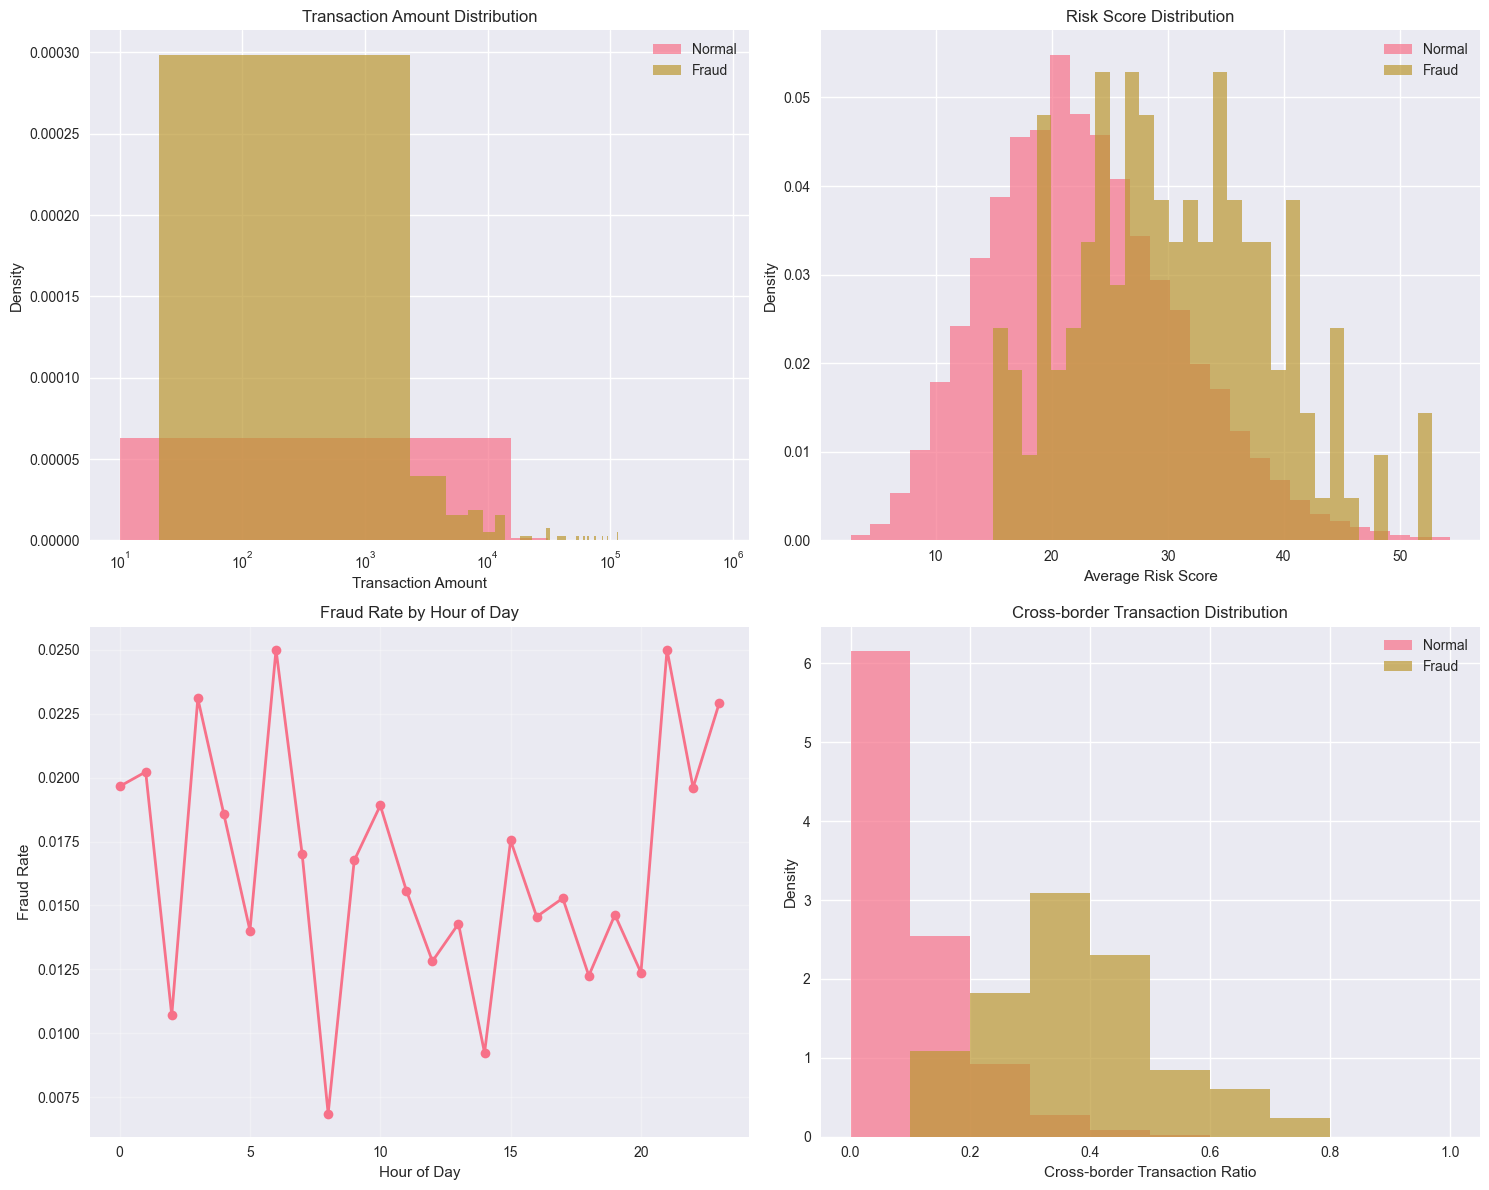

✅ Plot saved as: reports/figures/fraud_distribution_analysis.png


In [14]:
# Fraud Distribution Analysis
import os
os.makedirs('../reports/figures', exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Transaction Amount Distribution
axes[0,0].hist(df_engineered[df_engineered['is_fraud']==0]['transaction_amount'], 
               bins=50, alpha=0.7, label='Normal', density=True)
axes[0,0].hist(df_engineered[df_engineered['is_fraud']==1]['transaction_amount'], 
               bins=50, alpha=0.7, label='Fraud', density=True)
axes[0,0].set_xlabel('Transaction Amount')
axes[0,0].set_ylabel('Density')
axes[0,0].set_title('Transaction Amount Distribution')
axes[0,0].legend()
axes[0,0].set_xscale('log')

# 2. Risk Score Distribution
risk_cols = ['customer_risk_score', 'merchant_risk_score', 'geographic_risk_score']
risk_data_normal = df_engineered[df_engineered['is_fraud']==0][risk_cols].mean(axis=1)
risk_data_fraud = df_engineered[df_engineered['is_fraud']==1][risk_cols].mean(axis=1)

axes[0,1].hist(risk_data_normal, bins=30, alpha=0.7, label='Normal', density=True)
axes[0,1].hist(risk_data_fraud, bins=30, alpha=0.7, label='Fraud', density=True)
axes[0,1].set_xlabel('Average Risk Score')
axes[0,1].set_ylabel('Density')
axes[0,1].set_title('Risk Score Distribution')
axes[0,1].legend()

# 3. Time Pattern Analysis
time_fraud = df_engineered[df_engineered['is_fraud']==1]['hour'].value_counts().sort_index()
time_normal = df_engineered[df_engineered['is_fraud']==0]['hour'].value_counts().sort_index()
time_fraud_rate = time_fraud / (time_fraud + time_normal)

axes[1,0].plot(time_fraud_rate.index, time_fraud_rate.values, marker='o', linewidth=2)
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].set_ylabel('Fraud Rate')
axes[1,0].set_title('Fraud Rate by Hour of Day')
axes[1,0].grid(True, alpha=0.3)

# 4. Cross-border Transaction Analysis
cross_border_bins = np.linspace(0, 1, 11)
cb_normal = df_engineered[df_engineered['is_fraud']==0]['cross_border_transactions']
cb_fraud = df_engineered[df_engineered['is_fraud']==1]['cross_border_transactions']

axes[1,1].hist(cb_normal, bins=cross_border_bins, alpha=0.7, label='Normal', density=True)
axes[1,1].hist(cb_fraud, bins=cross_border_bins, alpha=0.7, label='Fraud', density=True)
axes[1,1].set_xlabel('Cross-border Transaction Ratio')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Cross-border Transaction Distribution')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/fraud_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved as: reports/figures/fraud_distribution_analysis.png")

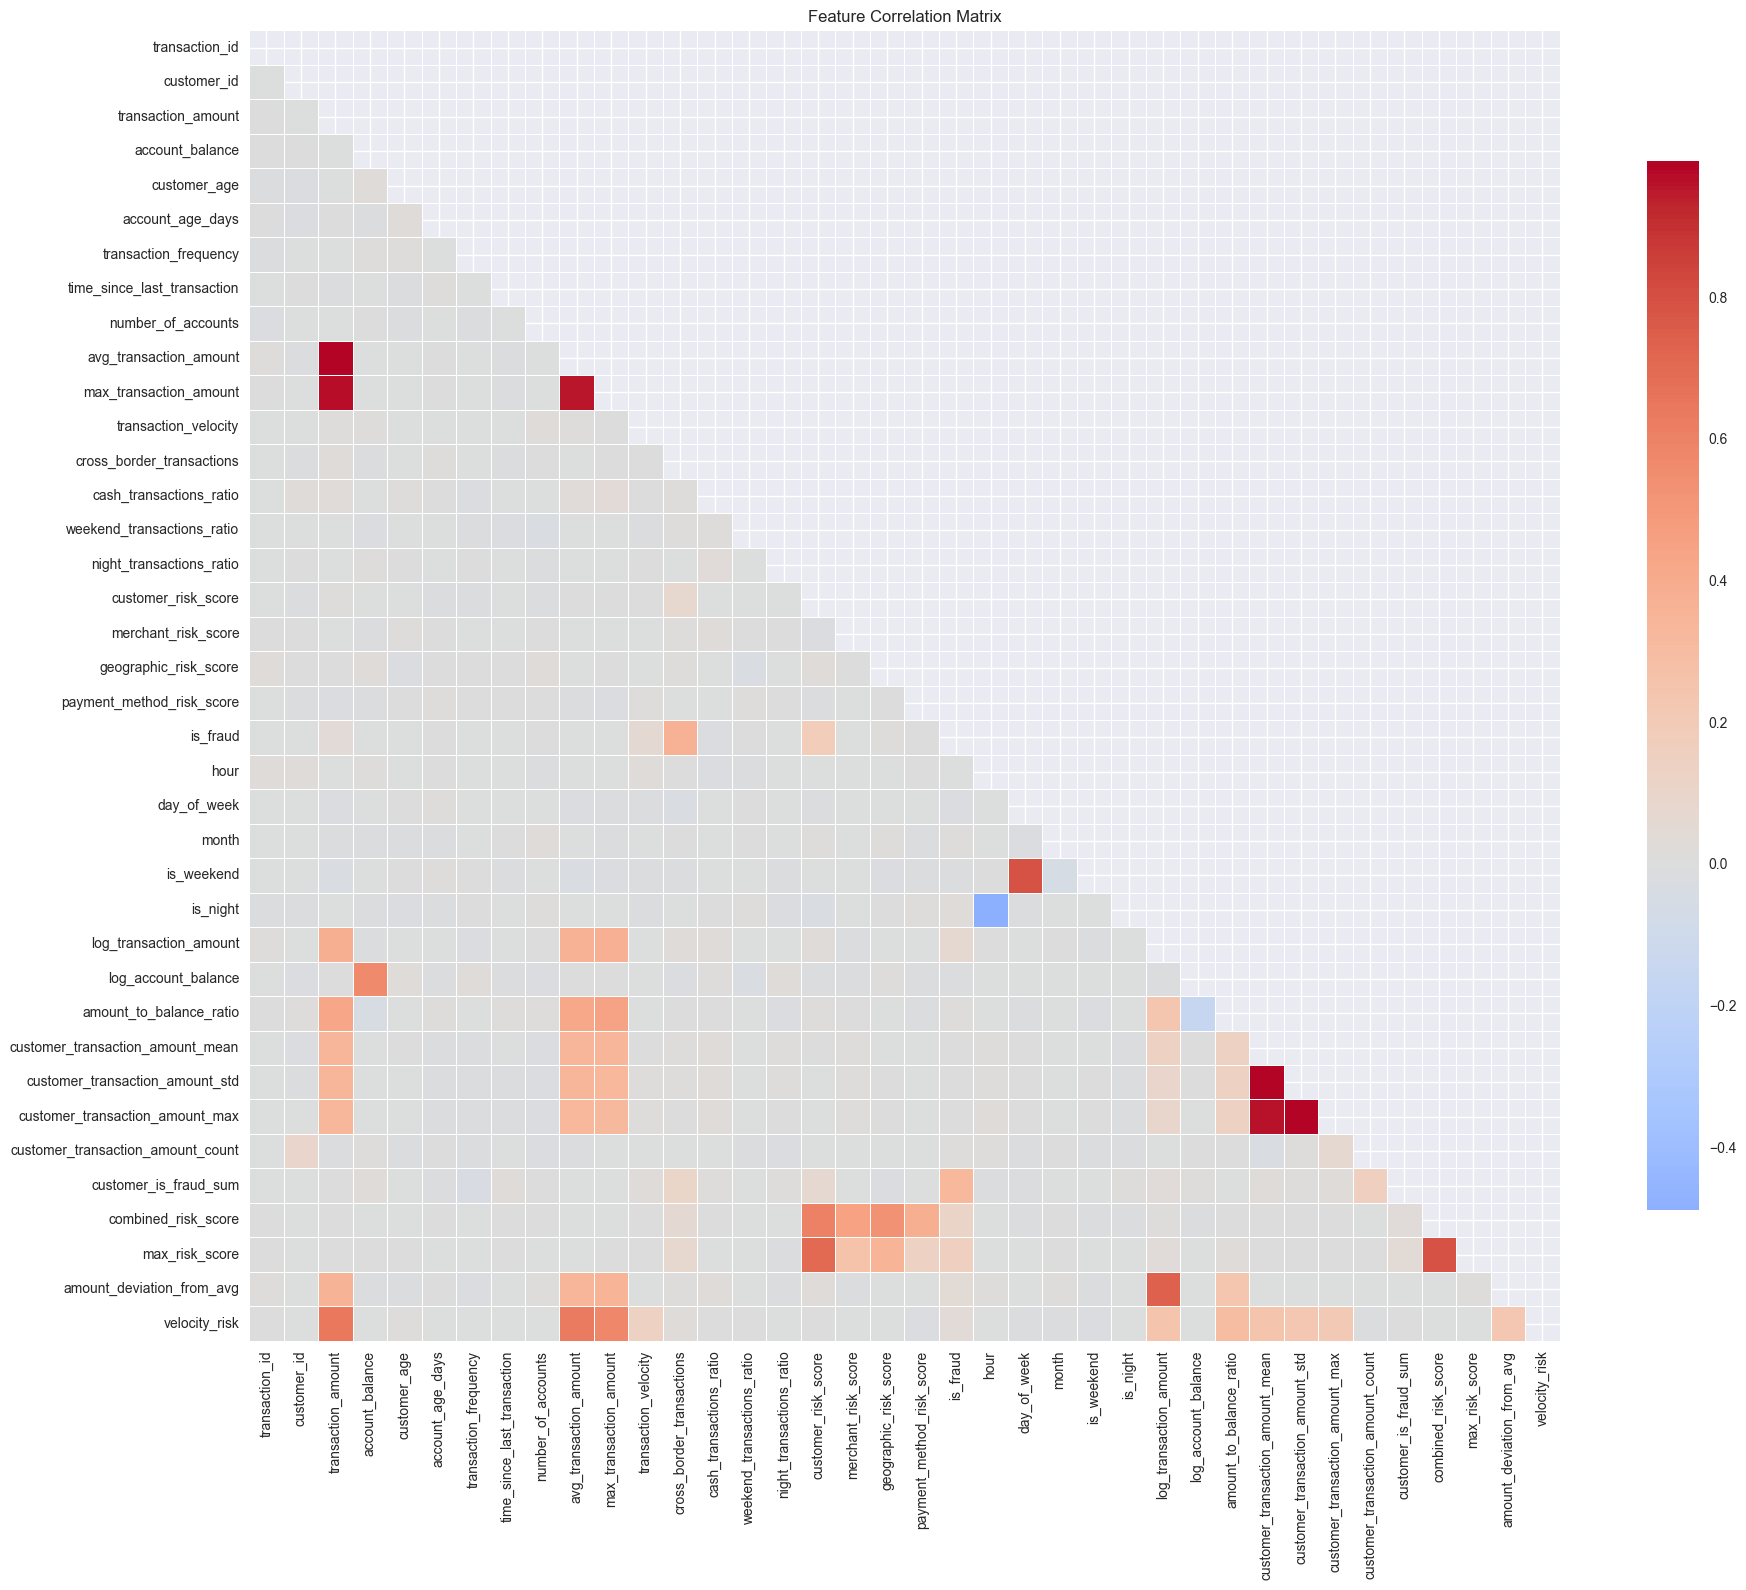

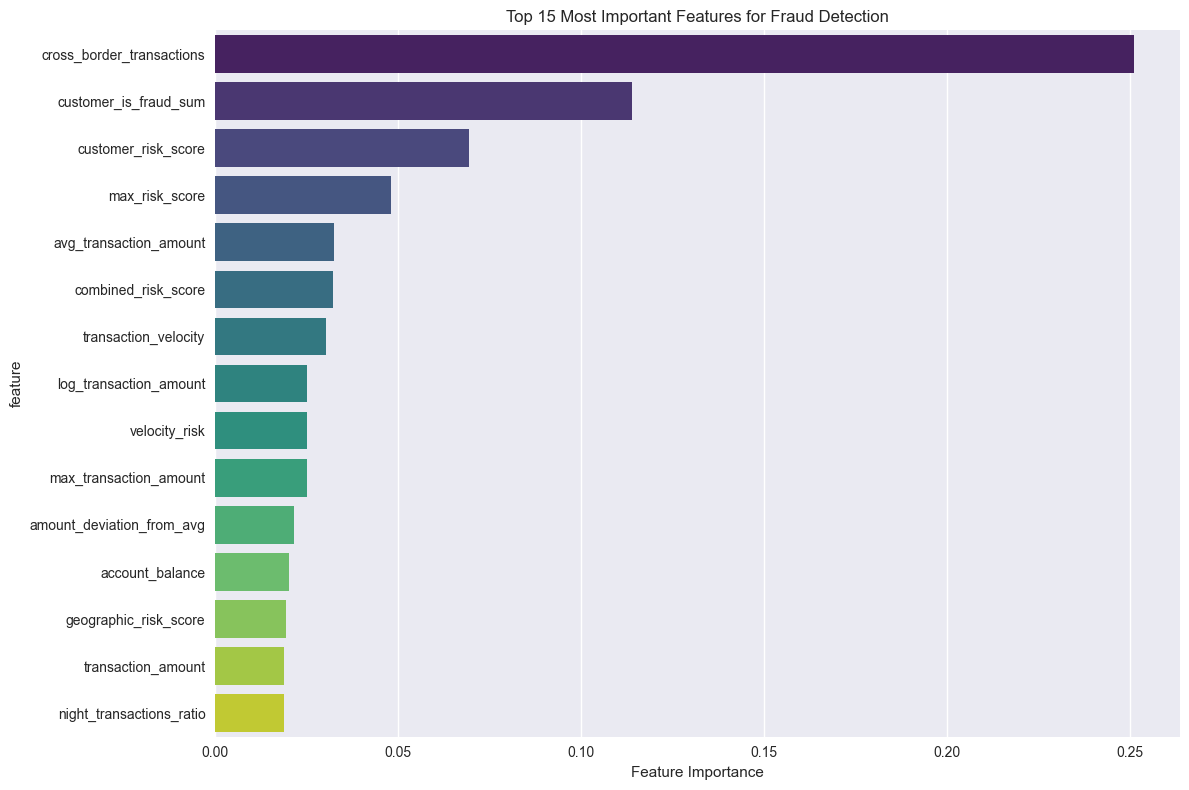

Top 10 Most Important Features:
                      feature  importance
10  cross_border_transactions    0.251094
30      customer_is_fraud_sum    0.113794
14        customer_risk_score    0.069278
32             max_risk_score    0.048120
7      avg_transaction_amount    0.032440
31        combined_risk_score    0.032172
9        transaction_velocity    0.030220
23     log_transaction_amount    0.025149
34              velocity_risk    0.025106
8      max_transaction_amount    0.025069

✅ Plots saved as:
- reports/figures/correlation_matrix.png
- reports/figures/feature_importance.png


In [15]:
# Correlation Analysis
# Select numerical features for correlation analysis
numerical_features = df_engineered.select_dtypes(include=[np.number]).columns
correlation_data = df_engineered[numerical_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(correlation_data, dtype=bool))
sns.heatmap(correlation_data, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('../reports/figures/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance analysis using Random Forest
feature_cols = [col for col in numerical_features if col not in ['transaction_id', 'customer_id', 'is_fraud']]
X_temp = df_engineered[feature_cols].fillna(0)
y_temp = df_engineered['is_fraud']

# Quick Random Forest for feature importance
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_temp, y_temp)

# Get feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 15 Most Important Features for Fraud Detection')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.savefig('../reports/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Top 10 Most Important Features:")
print(importance_df.head(10))
print("\n✅ Plots saved as:")
print("- reports/figures/correlation_matrix.png")
print("- reports/figures/feature_importance.png")

## 4. Historical Data Analysis for Dynamic Thresholds

We'll analyze historical patterns to establish baseline metrics for dynamic threshold calculation.

In [6]:
# Historical Pattern Analysis for Dynamic Thresholds
def calculate_customer_baselines(df):
    """Calculate baseline metrics for each customer"""
    
    # Sort by timestamp to get chronological order
    df_sorted = df.sort_values(['customer_id', 'timestamp'])
    
    # Calculate rolling statistics for each customer
    customer_baselines = []
    
    for customer_id in df_sorted['customer_id'].unique():
        customer_data = df_sorted[df_sorted['customer_id'] == customer_id].copy()
        
        # Calculate rolling averages (30-day window)
        customer_data['rolling_avg_amount'] = customer_data['transaction_amount'].rolling(
            window=min(10, len(customer_data)), min_periods=1).mean()
        customer_data['rolling_std_amount'] = customer_data['transaction_amount'].rolling(
            window=min(10, len(customer_data)), min_periods=1).std().fillna(0)
        
        # Calculate transaction frequency (transactions per day)
        customer_data['date'] = customer_data['timestamp'].dt.date
        daily_counts = customer_data.groupby('date').size()
        avg_daily_transactions = daily_counts.mean()
        std_daily_transactions = daily_counts.std() if len(daily_counts) > 1 else 0
        
        # Time-based patterns
        hour_pattern = customer_data['hour'].value_counts(normalize=True)
        most_common_hours = hour_pattern.head(3).index.tolist()
        
        # Behavioral baseline
        avg_cross_border = customer_data['cross_border_transactions'].mean()
        avg_cash_ratio = customer_data['cash_transactions_ratio'].mean()
        avg_risk_score = customer_data['combined_risk_score'].mean()
        
        baseline = {
            'customer_id': customer_id,
            'avg_transaction_amount': customer_data['transaction_amount'].mean(),
            'std_transaction_amount': customer_data['transaction_amount'].std(),
            'median_transaction_amount': customer_data['transaction_amount'].median(),
            'q75_transaction_amount': customer_data['transaction_amount'].quantile(0.75),
            'q95_transaction_amount': customer_data['transaction_amount'].quantile(0.95),
            'avg_daily_transactions': avg_daily_transactions,
            'std_daily_transactions': std_daily_transactions if not np.isnan(std_daily_transactions) else 0,
            'most_common_hours': most_common_hours,
            'avg_cross_border_ratio': avg_cross_border,
            'avg_cash_ratio': avg_cash_ratio,
            'avg_risk_score': avg_risk_score,
            'total_transactions': len(customer_data),
            'account_age_days': customer_data['account_age_days'].iloc[-1],
            'customer_age': customer_data['customer_age'].iloc[0]
        }
        
        customer_baselines.append(baseline)
    
    return pd.DataFrame(customer_baselines)

# Calculate customer baselines
print("Calculating customer baselines...")
customer_baselines = calculate_customer_baselines(df_engineered)

print(f"Calculated baselines for {len(customer_baselines)} customers")
customer_baselines.head()

Calculating customer baselines...
Calculated baselines for 1249 customers


,customer_id,avg_transaction_amount,std_transaction_amount,median_transaction_amount,q75_transaction_amount,q95_transaction_amount,avg_daily_transactions,std_daily_transactions,most_common_hours,avg_cross_border_ratio,avg_cash_ratio,avg_risk_score,total_transactions,account_age_days,customer_age
0,1,2518.150359,4532.941325,385.778078,1727.127231,12455.828117,1.083333,0.288675,"[11, 3, 10]",0.115804,0.151238,19.526509,13,2472.733140,70.409770
1,2,966.324032,973.984386,640.950620,1378.102467,2366.755952,1.200000,0.447214,"[11, 12, 16]",0.095315,0.198270,25.425082,6,809.395025,39.217787
2,3,3718.905066,6802.592745,813.053684,2342.248080,13790.517803,1.000000,0.000000,"[13, 4, 17]",0.088489,0.147906,22.158609,6,431.805900,28.675476
3,4,959.262067,1227.692302,370.566070,892.769232,2657.386398,1.000000,0.000000,"[8, 4, 12]",0.139318,0.234123,22.822837,5,1122.049276,72.433795
4,5,4417.844140,9634.116125,118.250216,214.710722,17364.064305,1.000000,0.000000,"[18, 21, 12]",0.151695,0.169522,17.724451,5,1724.974765,63.917183


Dynamic Thresholds Sample:
   customer_id  amount_threshold_upper  frequency_threshold  risk_threshold  \
0            1            13850.503671             1.805021       39.526509   
1            2             3401.284998             2.318034       45.425082   
2            3            20725.386928             1.000000       42.158609   
3            4             4028.492822             1.000000       42.822837   
4            5            28503.134451             1.000000       37.724451   

   cross_border_threshold  
0                0.415804  
1                0.395315  
2                0.388489  
3                0.439318  
4                0.451695  


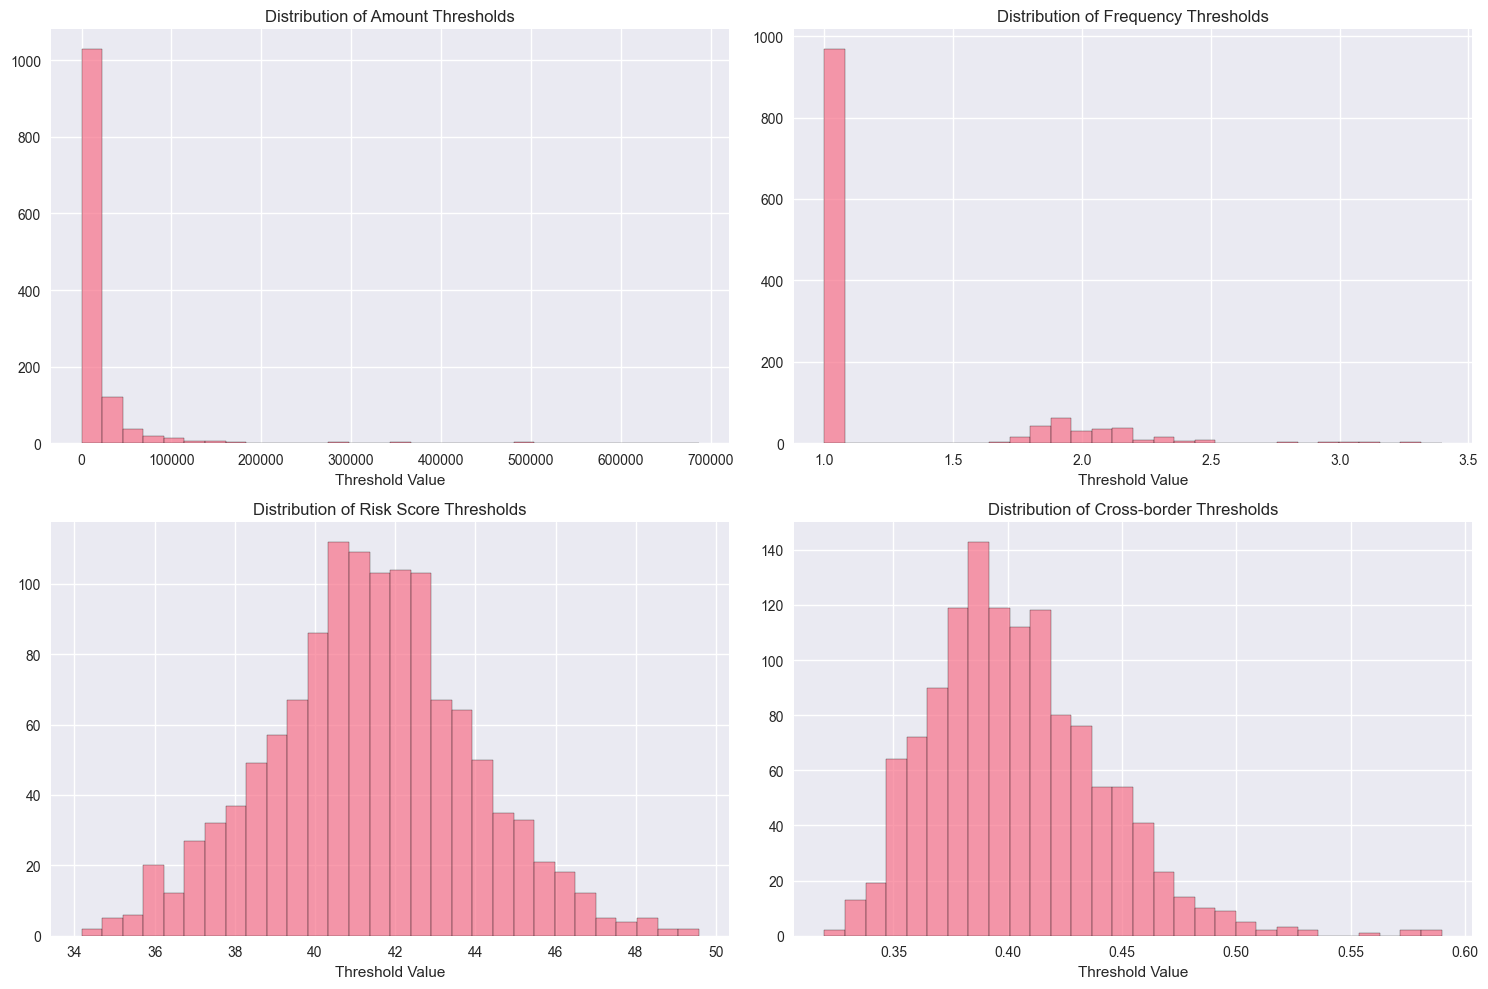


✅ Plot saved as: reports/figures/dynamic_thresholds_distribution.png


In [16]:
# Dynamic Threshold Calculation
def calculate_dynamic_thresholds(customer_baselines, multiplier=2.5):
    """Calculate dynamic thresholds based on customer historical data"""
    
    thresholds = customer_baselines.copy()
    
    # Amount-based thresholds
    thresholds['amount_threshold_upper'] = (
        thresholds['avg_transaction_amount'] + 
        multiplier * thresholds['std_transaction_amount']
    )
    
    thresholds['amount_threshold_high'] = thresholds['q95_transaction_amount']
    
    # Frequency-based thresholds
    thresholds['frequency_threshold'] = (
        thresholds['avg_daily_transactions'] + 
        multiplier * thresholds['std_daily_transactions']
    )
    
    # Risk-based thresholds (percentile approach)
    overall_risk_95 = customer_baselines['avg_risk_score'].quantile(0.95)
    thresholds['risk_threshold'] = np.maximum(
        thresholds['avg_risk_score'] + 20,  # 20 points above average
        overall_risk_95 * 0.8  # or 80% of 95th percentile
    )
    
    # Behavioral thresholds
    thresholds['cross_border_threshold'] = np.minimum(
        thresholds['avg_cross_border_ratio'] + 0.3,  # 30% increase
        0.8  # Cap at 80%
    )
    
    thresholds['cash_ratio_threshold'] = np.minimum(
        thresholds['avg_cash_ratio'] + 0.4,  # 40% increase
        0.9  # Cap at 90%
    )
    
    return thresholds

# Calculate dynamic thresholds
dynamic_thresholds = calculate_dynamic_thresholds(customer_baselines)

print("Dynamic Thresholds Sample:")
sample_thresholds = dynamic_thresholds[['customer_id', 'amount_threshold_upper', 
                                      'frequency_threshold', 'risk_threshold', 
                                      'cross_border_threshold']].head()
print(sample_thresholds)

# Visualize threshold distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].hist(dynamic_thresholds['amount_threshold_upper'], bins=30, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribution of Amount Thresholds')
axes[0,0].set_xlabel('Threshold Value')

axes[0,1].hist(dynamic_thresholds['frequency_threshold'], bins=30, alpha=0.7, edgecolor='black')
axes[0,1].set_title('Distribution of Frequency Thresholds')
axes[0,1].set_xlabel('Threshold Value')

axes[1,0].hist(dynamic_thresholds['risk_threshold'], bins=30, alpha=0.7, edgecolor='black')
axes[1,0].set_title('Distribution of Risk Score Thresholds')
axes[1,0].set_xlabel('Threshold Value')

axes[1,1].hist(dynamic_thresholds['cross_border_threshold'], bins=30, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Distribution of Cross-border Thresholds')
axes[1,1].set_xlabel('Threshold Value')

plt.tight_layout()
plt.savefig('../reports/figures/dynamic_thresholds_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Plot saved as: reports/figures/dynamic_thresholds_distribution.png")

## 5. Comprehensive Dataset Analysis

Based on our exploration of the AML dataset, we can draw several important conclusions about fraud patterns and detection strategies.

In [8]:
# Comprehensive Dataset Analysis
print("=" * 80)
print("📊 COMPREHENSIVE AML DATASET ANALYSIS")
print("=" * 80)

# 1. Fraud Distribution Analysis
fraud_count = df_engineered['is_fraud'].sum()
total_count = len(df_engineered)
fraud_rate = fraud_count / total_count

print(f"\n🎯 FRAUD DISTRIBUTION:")
print(f"   • Total Transactions: {total_count:,}")
print(f"   • Fraudulent Transactions: {fraud_count:,}")
print(f"   • Fraud Rate: {fraud_rate:.3%}")
print(f"   • Normal Transactions: {total_count - fraud_count:,}")

# 2. Transaction Amount Analysis
fraud_amounts = df_engineered[df_engineered['is_fraud']==1]['transaction_amount']
normal_amounts = df_engineered[df_engineered['is_fraud']==0]['transaction_amount']

print(f"\n💰 TRANSACTION AMOUNT PATTERNS:")
print(f"   • Average Fraud Amount: ${fraud_amounts.mean():,.2f}")
print(f"   • Average Normal Amount: ${normal_amounts.mean():,.2f}")
print(f"   • Fraud vs Normal Ratio: {fraud_amounts.mean() / normal_amounts.mean():.2f}x")
print(f"   • Median Fraud Amount: ${fraud_amounts.median():,.2f}")
print(f"   • Median Normal Amount: ${normal_amounts.median():,.2f}")

# 3. Risk Score Analysis
fraud_risk = df_engineered[df_engineered['is_fraud']==1]['combined_risk_score'].mean()
normal_risk = df_engineered[df_engineered['is_fraud']==0]['combined_risk_score'].mean()

print(f"\n⚠️ RISK SCORE ANALYSIS:")
print(f"   • Average Fraud Risk Score: {fraud_risk:.2f}")
print(f"   • Average Normal Risk Score: {normal_risk:.2f}")
print(f"   • Risk Score Difference: {fraud_risk - normal_risk:.2f} points")

# 4. Behavioral Pattern Analysis
print(f"\n🕐 BEHAVIORAL PATTERNS:")

# Time patterns
fraud_by_hour = df_engineered[df_engineered['is_fraud']==1]['hour'].value_counts().sort_index()
peak_fraud_hour = fraud_by_hour.idxmax()
peak_fraud_count = fraud_by_hour.max()

print(f"   • Peak Fraud Hour: {peak_fraud_hour}:00 ({peak_fraud_count} transactions)")

# Cross-border analysis
fraud_cross_border = df_engineered[df_engineered['is_fraud']==1]['cross_border_transactions'].mean()
normal_cross_border = df_engineered[df_engineered['is_fraud']==0]['cross_border_transactions'].mean()

print(f"   • Fraud Cross-border Ratio: {fraud_cross_border:.3f}")
print(f"   • Normal Cross-border Ratio: {normal_cross_border:.3f}")
print(f"   • Cross-border Risk Factor: {fraud_cross_border / normal_cross_border:.2f}x")

# Cash transaction analysis
fraud_cash = df_engineered[df_engineered['is_fraud']==1]['cash_transactions_ratio'].mean()
normal_cash = df_engineered[df_engineered['is_fraud']==0]['cash_transactions_ratio'].mean()

print(f"   • Fraud Cash Transaction Ratio: {fraud_cash:.3f}")
print(f"   • Normal Cash Transaction Ratio: {normal_cash:.3f}")
print(f"   • Cash Transaction Risk Factor: {fraud_cash / normal_cash:.2f}x")

# 5. Customer Analysis
print(f"\n👥 CUSTOMER BEHAVIOR ANALYSIS:")

# Customer with highest fraud rate
customer_fraud_rates = df_engineered.groupby('customer_id')['is_fraud'].agg(['sum', 'count', 'mean'])
customer_fraud_rates = customer_fraud_rates[customer_fraud_rates['count'] >= 5]  # At least 5 transactions
highest_fraud_customer = customer_fraud_rates['mean'].idxmax()
highest_fraud_rate = customer_fraud_rates['mean'].max()

print(f"   • Customer with Highest Fraud Rate: Customer {highest_fraud_customer}")
print(f"   • Highest Fraud Rate: {highest_fraud_rate:.3%}")
print(f"   • Customers with 100% Fraud Rate: {(customer_fraud_rates['mean'] == 1.0).sum()}")
print(f"   • Customers with 0% Fraud Rate: {(customer_fraud_rates['mean'] == 0.0).sum()}")

# 6. Feature Importance Insights
print(f"\n🔍 KEY FRAUD INDICATORS (Top 5):")
top_5_features = importance_df.head(5)
for idx, row in top_5_features.iterrows():
    print(f"   • {row['feature']}: {row['importance']:.4f}")

# 7. Dynamic Threshold Effectiveness
print(f"\n🎚️ DYNAMIC THRESHOLD ANALYSIS:")
print(f"   • Number of Customers: {len(dynamic_thresholds)}")
print(f"   • Average Amount Threshold: ${dynamic_thresholds['amount_threshold_upper'].mean():,.2f}")
print(f"   • Average Risk Threshold: {dynamic_thresholds['risk_threshold'].mean():.2f}")
print(f"   • Cross-border Threshold Range: {dynamic_thresholds['cross_border_threshold'].min():.3f} - {dynamic_thresholds['cross_border_threshold'].max():.3f}")

# 8. Detection Opportunity Analysis
high_amount_fraud = (fraud_amounts > fraud_amounts.quantile(0.75)).sum()
high_risk_fraud = (df_engineered[df_engineered['is_fraud']==1]['combined_risk_score'] > 70).sum()
night_fraud = (df_engineered[df_engineered['is_fraud']==1]['is_night'] == 1).sum()

print(f"\n🎯 DETECTION OPPORTUNITIES:")
print(f"   • High Amount Frauds (>75th percentile): {high_amount_fraud}/{fraud_count} ({high_amount_fraud/fraud_count:.1%})")
print(f"   • High Risk Score Frauds (>70): {high_risk_fraud}/{fraud_count} ({high_risk_fraud/fraud_count:.1%})")
print(f"   • Night-time Frauds: {night_fraud}/{fraud_count} ({night_fraud/fraud_count:.1%})")

print(f"\n" + "=" * 80)
print("✅ ANALYSIS COMPLETE - All insights generated and plots saved!")
print("=" * 80)

📊 COMPREHENSIVE AML DATASET ANALYSIS

🎯 FRAUD DISTRIBUTION:
   • Total Transactions: 10,000
   • Fraudulent Transactions: 165
   • Fraud Rate: 1.650%
   • Normal Transactions: 9,835

💰 TRANSACTION AMOUNT PATTERNS:
   • Average Fraud Amount: $7,449.82
   • Average Normal Amount: $2,991.66
   • Fraud vs Normal Ratio: 2.49x
   • Median Fraud Amount: $994.89
   • Median Normal Amount: $411.76

⚠️ RISK SCORE ANALYSIS:
   • Average Fraud Risk Score: 27.19
   • Average Normal Risk Score: 21.28
   • Risk Score Difference: 5.92 points

🕐 BEHAVIORAL PATTERNS:
   • Peak Fraud Hour: 21:00 (11 transactions)
   • Fraud Cross-border Ratio: 0.380
   • Normal Cross-border Ratio: 0.099
   • Cross-border Risk Factor: 3.83x
   • Fraud Cash Transaction Ratio: 0.141
   • Normal Cash Transaction Ratio: 0.159
   • Cash Transaction Risk Factor: 0.89x

👥 CUSTOMER BEHAVIOR ANALYSIS:
   • Customer with Highest Fraud Rate: Customer 283
   • Highest Fraud Rate: 27.273%
   • Customers with 100% Fraud Rate: 0
   • Cu

## 6. Machine Learning Models Implementation

Now we'll implement the core ML algorithms for AML fraud detection:
- **Anomaly Detection**: Isolation Forest, One-Class SVM, Local Outlier Factor
- **Clustering**: K-Means and DBSCAN for pattern discovery
- **Supervised Learning**: Random Forest and XGBoost for classification

Features for modeling: 35
Dataset shape: (10000, 35)
Features: ['transaction_amount', 'account_balance', 'customer_age', 'account_age_days', 'transaction_frequency', 'time_since_last_transaction', 'number_of_accounts', 'avg_transaction_amount', 'max_transaction_amount', 'transaction_velocity']...

🔍 ANOMALY DETECTION MODELS

1. Isolation Forest:
   • Anomalies detected: 200 (2.000%)
   • Precision: 0.070
   • Recall: 0.085

2. One-Class SVM:
   • Anomalies detected: 220 (2.200%)
   • Precision: 0.077
   • Recall: 0.103

3. Local Outlier Factor:
   • Anomalies detected: 200 (2.000%)
   • Precision: 0.100
   • Recall: 0.121


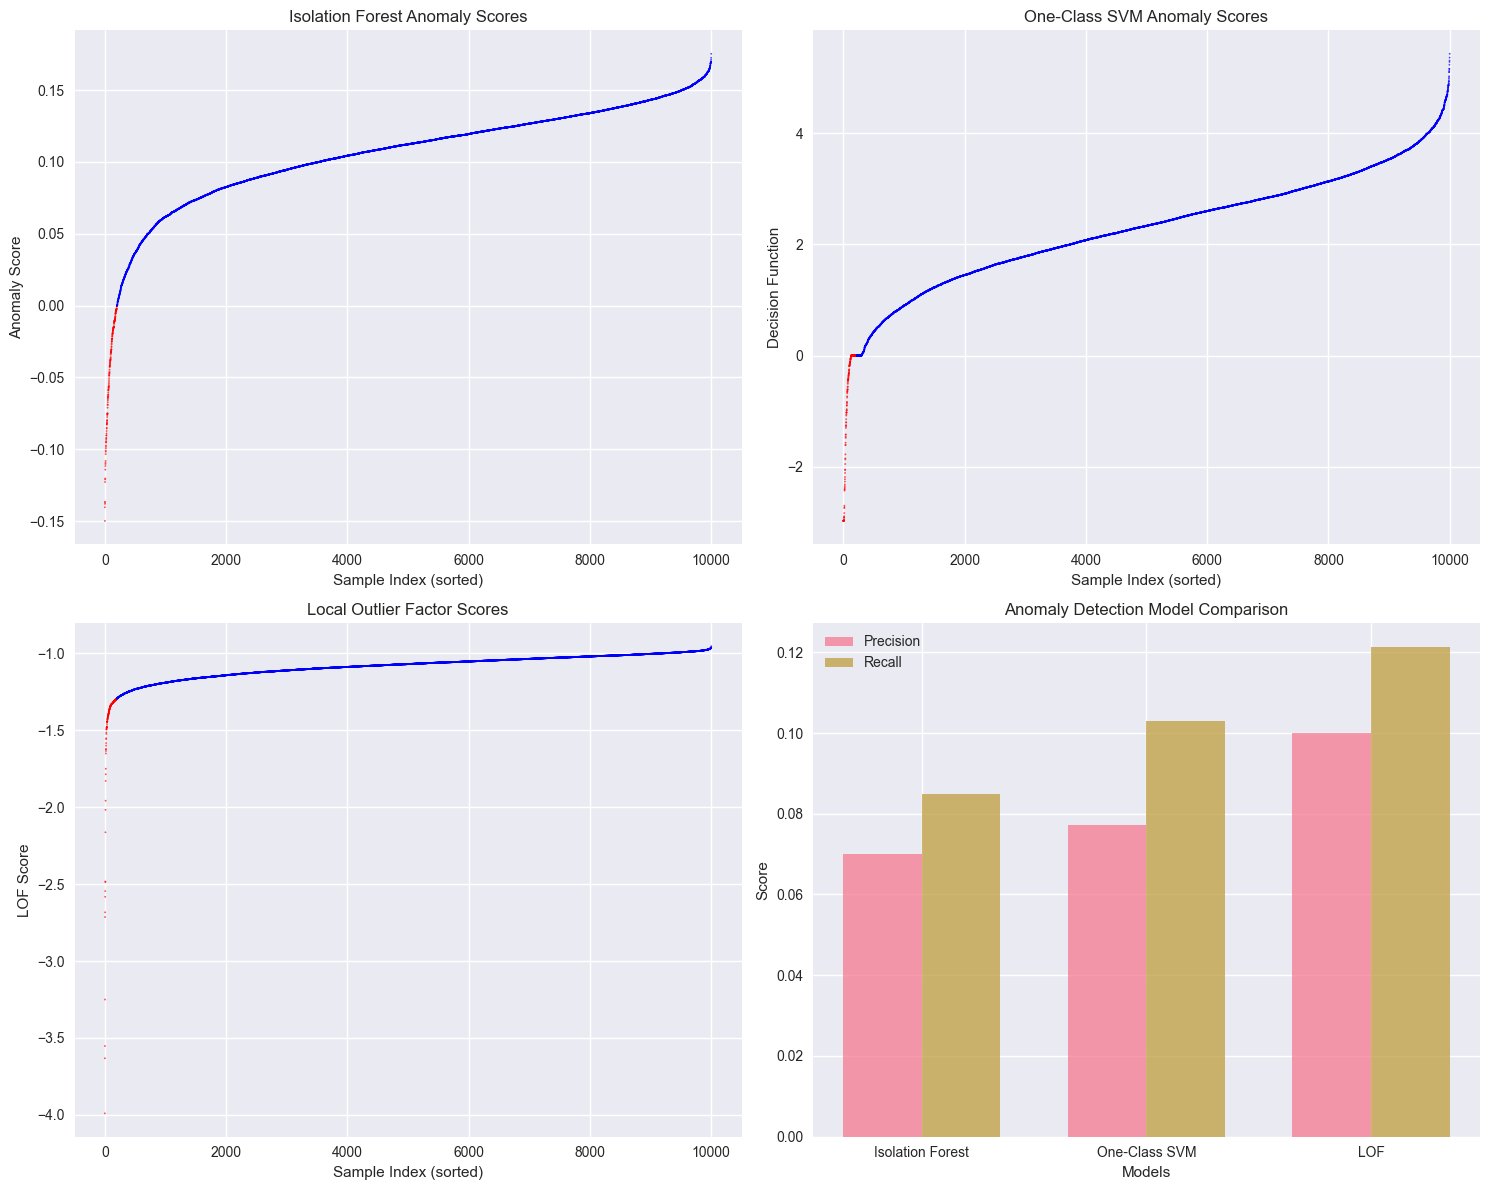


✅ Plot saved as: reports/figures/anomaly_detection_results.png


In [10]:
# Prepare data for machine learning
# Select features for modeling
feature_cols = [col for col in df_engineered.columns if col not in 
                ['transaction_id', 'customer_id', 'timestamp', 'is_fraud']]
X = df_engineered[feature_cols].fillna(0)
y = df_engineered['is_fraud']

# Scale features for models that require it
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features for modeling: {len(feature_cols)}")
print(f"Dataset shape: {X.shape}")
print(f"Features: {feature_cols[:10]}...")  # Show first 10 features

# 1. ANOMALY DETECTION MODELS
print("\n" + "="*60)
print("🔍 ANOMALY DETECTION MODELS")
print("="*60)

# Isolation Forest
print("\n1. Isolation Forest:")
iso_forest = IsolationForest(contamination=0.02, random_state=42, n_estimators=100)
iso_predictions = iso_forest.fit_predict(X_scaled)
iso_scores = iso_forest.decision_function(X_scaled)

# Convert predictions (-1 for outliers, 1 for inliers) to (1 for outliers, 0 for inliers)
iso_predictions = (iso_predictions == -1).astype(int)

print(f"   • Anomalies detected: {iso_predictions.sum()} ({iso_predictions.mean():.3%})")
print(f"   • Precision: {(iso_predictions & y).sum() / iso_predictions.sum():.3f}")
print(f"   • Recall: {(iso_predictions & y).sum() / y.sum():.3f}")

# One-Class SVM
print("\n2. One-Class SVM:")
oc_svm = OneClassSVM(nu=0.02, kernel='rbf', gamma='scale')
oc_predictions = oc_svm.fit_predict(X_scaled)
oc_scores = oc_svm.decision_function(X_scaled)

# Convert predictions
oc_predictions = (oc_predictions == -1).astype(int)

print(f"   • Anomalies detected: {oc_predictions.sum()} ({oc_predictions.mean():.3%})")
print(f"   • Precision: {(oc_predictions & y).sum() / oc_predictions.sum():.3f}")
print(f"   • Recall: {(oc_predictions & y).sum() / y.sum():.3f}")

# Local Outlier Factor
print("\n3. Local Outlier Factor:")
lof = LocalOutlierFactor(contamination=0.02, novelty=False)
lof_predictions = lof.fit_predict(X_scaled)
lof_scores = lof.negative_outlier_factor_

# Convert predictions
lof_predictions = (lof_predictions == -1).astype(int)

print(f"   • Anomalies detected: {lof_predictions.sum()} ({lof_predictions.mean():.3%})")
print(f"   • Precision: {(lof_predictions & y).sum() / lof_predictions.sum():.3f}")
print(f"   • Recall: {(lof_predictions & y).sum() / y.sum():.3f}")

# Visualize anomaly detection results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Isolation Forest scores
axes[0,0].scatter(range(len(iso_scores)), sorted(iso_scores), 
                 c=['red' if pred else 'blue' for pred in iso_predictions[np.argsort(iso_scores)]], 
                 alpha=0.6, s=1)
axes[0,0].set_title('Isolation Forest Anomaly Scores')
axes[0,0].set_xlabel('Sample Index (sorted)')
axes[0,0].set_ylabel('Anomaly Score')

# Plot 2: One-Class SVM scores  
axes[0,1].scatter(range(len(oc_scores)), sorted(oc_scores),
                 c=['red' if pred else 'blue' for pred in oc_predictions[np.argsort(oc_scores)]], 
                 alpha=0.6, s=1)
axes[0,1].set_title('One-Class SVM Anomaly Scores')
axes[0,1].set_xlabel('Sample Index (sorted)')
axes[0,1].set_ylabel('Decision Function')

# Plot 3: LOF scores
axes[1,0].scatter(range(len(lof_scores)), sorted(lof_scores),
                 c=['red' if pred else 'blue' for pred in lof_predictions[np.argsort(lof_scores)]], 
                 alpha=0.6, s=1)
axes[1,0].set_title('Local Outlier Factor Scores')
axes[1,0].set_xlabel('Sample Index (sorted)')
axes[1,0].set_ylabel('LOF Score')

# Plot 4: Model comparison
models = ['Isolation Forest', 'One-Class SVM', 'LOF']
precisions = [
    (iso_predictions & y).sum() / iso_predictions.sum(),
    (oc_predictions & y).sum() / oc_predictions.sum(),
    (lof_predictions & y).sum() / lof_predictions.sum()
]
recalls = [
    (iso_predictions & y).sum() / y.sum(),
    (oc_predictions & y).sum() / y.sum(),
    (lof_predictions & y).sum() / y.sum()
]

x_pos = np.arange(len(models))
width = 0.35

axes[1,1].bar(x_pos - width/2, precisions, width, label='Precision', alpha=0.7)
axes[1,1].bar(x_pos + width/2, recalls, width, label='Recall', alpha=0.7)
axes[1,1].set_xlabel('Models')
axes[1,1].set_ylabel('Score')
axes[1,1].set_title('Anomaly Detection Model Comparison')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(models)
axes[1,1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/anomaly_detection_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Plot saved as: reports/figures/anomaly_detection_results.png")


🎯 CLUSTERING ANALYSIS

1. K-Means Clustering:
   K-Means Cluster Analysis:
   • Cluster 0: 3497 transactions, 110 frauds (3.146%)
   • Cluster 1: 1496 transactions, 33 frauds (2.206%)
   • Cluster 2: 4914 transactions, 22 frauds (0.448%)
   • Cluster 3: 74 transactions, 0 frauds (0.000%)
   • Cluster 4: 19 transactions, 0 frauds (0.000%)

2. DBSCAN Clustering:
   • Number of clusters: 0
   • Number of noise points: 10000 (100.000%)
   • Fraud rate in noise points: 1.650%


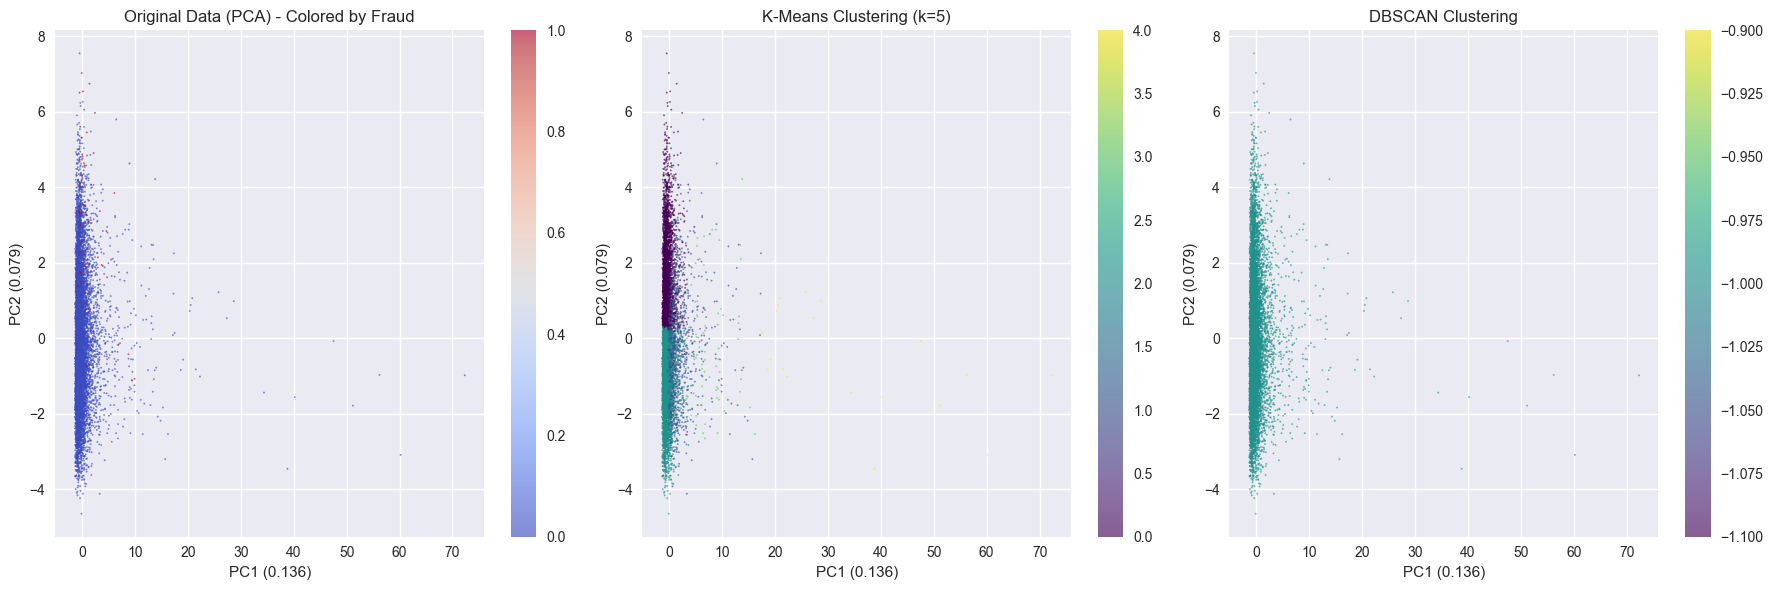


✅ Plot saved as: reports/figures/clustering_analysis.png


In [11]:
# 2. CLUSTERING ANALYSIS
print("\n" + "="*60)
print("🎯 CLUSTERING ANALYSIS")
print("="*60)

# K-Means Clustering
print("\n1. K-Means Clustering:")
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Analyze fraud rate by cluster
cluster_analysis = pd.DataFrame({
    'cluster': kmeans_labels,
    'is_fraud': y
})
cluster_fraud_rates = cluster_analysis.groupby('cluster')['is_fraud'].agg(['count', 'sum', 'mean'])
cluster_fraud_rates.columns = ['total_transactions', 'fraud_count', 'fraud_rate']

print("   K-Means Cluster Analysis:")
for cluster in range(5):
    total = cluster_fraud_rates.loc[cluster, 'total_transactions']
    frauds = cluster_fraud_rates.loc[cluster, 'fraud_count']
    rate = cluster_fraud_rates.loc[cluster, 'fraud_rate']
    print(f"   • Cluster {cluster}: {total} transactions, {frauds} frauds ({rate:.3%})")

# DBSCAN Clustering
print("\n2. DBSCAN Clustering:")
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Analyze DBSCAN results
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"   • Number of clusters: {n_clusters_dbscan}")
print(f"   • Number of noise points: {n_noise} ({n_noise/len(dbscan_labels):.3%})")

# Analyze fraud in noise points (potential outliers)
noise_mask = dbscan_labels == -1
noise_fraud_rate = y[noise_mask].mean() if noise_mask.sum() > 0 else 0
print(f"   • Fraud rate in noise points: {noise_fraud_rate:.3%}")

# Visualize clustering results using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original data colored by fraud
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6, s=1)
axes[0].set_title('Original Data (PCA) - Colored by Fraud')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
plt.colorbar(scatter1, ax=axes[0])

# Plot 2: K-Means clusters
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6, s=1)
axes[1].set_title('K-Means Clustering (k=5)')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
plt.colorbar(scatter2, ax=axes[1])

# Plot 3: DBSCAN clusters
scatter3 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6, s=1)
axes[2].set_title('DBSCAN Clustering')
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
plt.colorbar(scatter3, ax=axes[2])

plt.tight_layout()
plt.savefig('../reports/figures/clustering_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Plot saved as: reports/figures/clustering_analysis.png")


🚀 SUPERVISED LEARNING MODELS
Training set: 8000 samples
Test set: 2000 samples
Training fraud rate: 1.650%
Test fraud rate: 1.650%

1. Random Forest Classifier:
   Random Forest Results:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00      1967
       Fraud       0.81      0.67      0.73        33

    accuracy                           0.99      2000
   macro avg       0.90      0.83      0.86      2000
weighted avg       0.99      0.99      0.99      2000


2. XGBoost Classifier:
   XGBoost Results:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1967
       Fraud       0.96      0.79      0.87        33

    accuracy                           1.00      2000
   macro avg       0.98      0.89      0.93      2000
weighted avg       1.00      1.00      1.00      2000



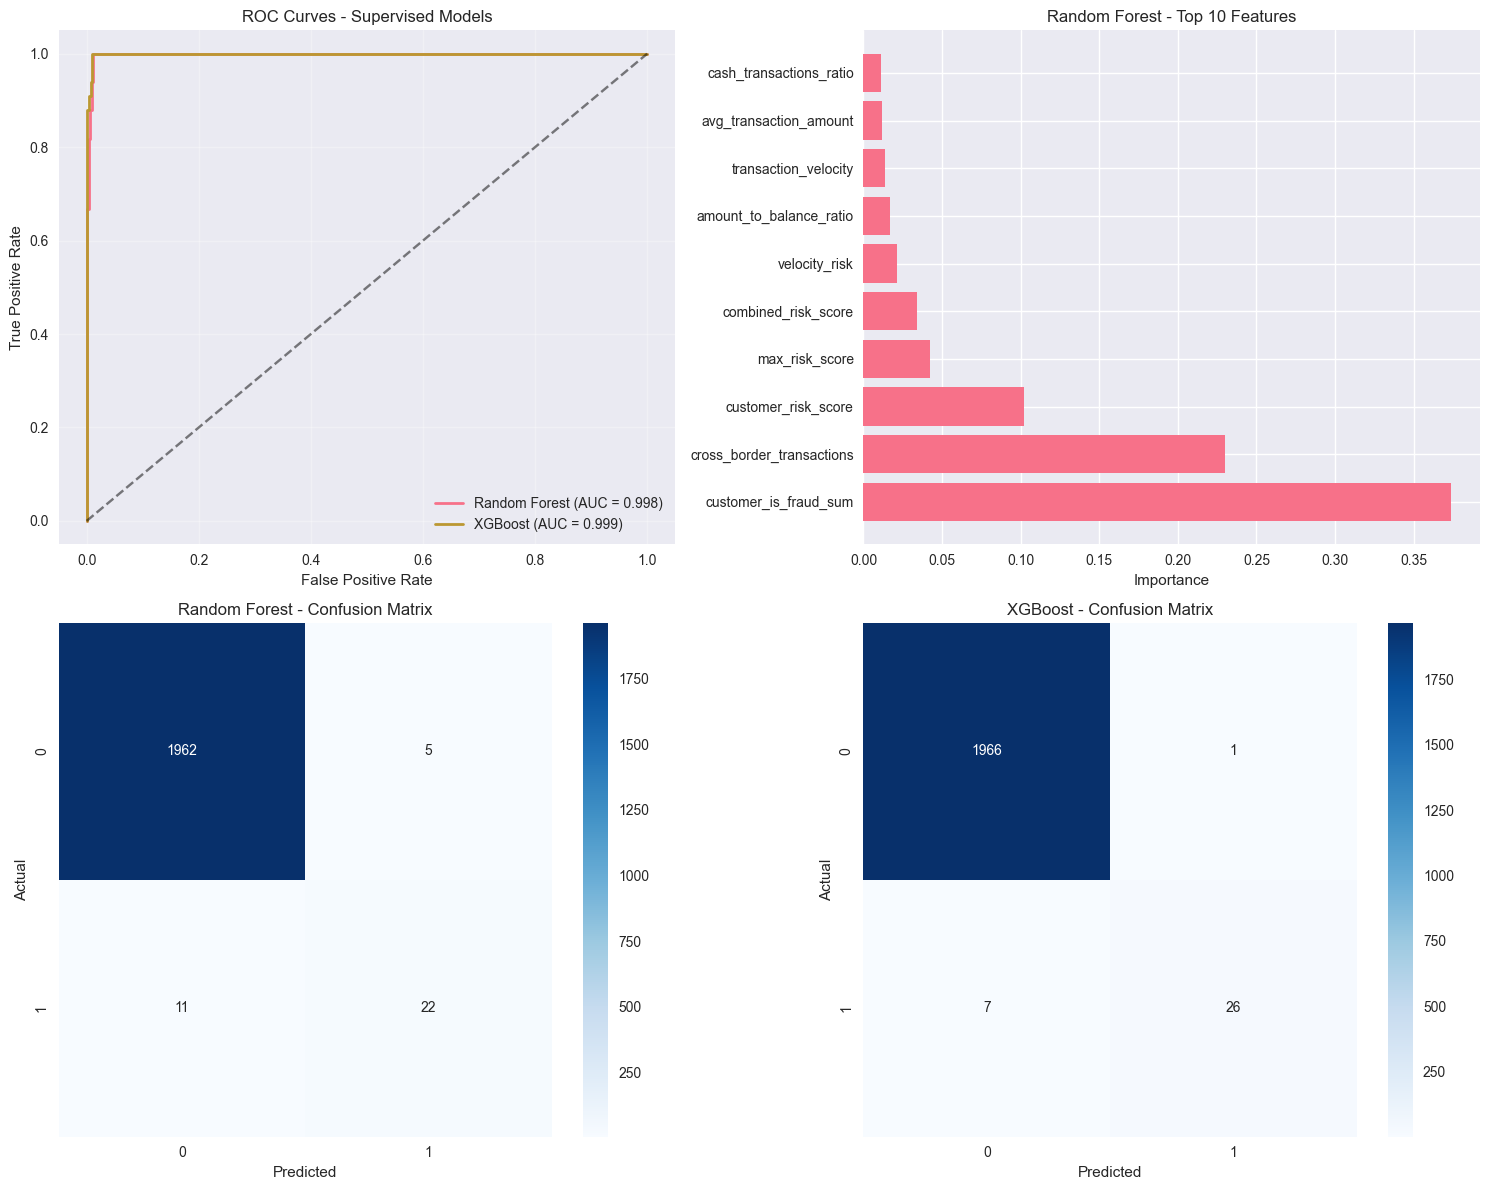


📊 MODEL PERFORMANCE SUMMARY:
   • Random Forest AUC: 0.998
   • XGBoost AUC: 0.999

✅ Plot saved as: reports/figures/supervised_learning_results.png


In [12]:
# 3. SUPERVISED LEARNING MODELS
print("\n" + "="*60)
print("🚀 SUPERVISED LEARNING MODELS")
print("="*60)

# Split data for supervised learning
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training fraud rate: {y_train.mean():.3%}")
print(f"Test fraud rate: {y_test.mean():.3%}")

# Random Forest Classifier
print("\n1. Random Forest Classifier:")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

print("   Random Forest Results:")
print(classification_report(y_test, rf_pred, target_names=['Normal', 'Fraud']))

# XGBoost Classifier
print("\n2. XGBoost Classifier:")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

print("   XGBoost Results:")
print(classification_report(y_test, xgb_pred, target_names=['Normal', 'Fraud']))

# Calculate ROC curves
from sklearn.metrics import roc_curve, auc

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba)
rf_auc = auc(rf_fpr, rf_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_proba)
xgb_auc = auc(xgb_fpr, xgb_tpr)

# Visualize supervised learning results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: ROC Curves
axes[0,0].plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.3f})', linewidth=2)
axes[0,0].plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.3f})', linewidth=2)
axes[0,0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curves - Supervised Models')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Feature Importance (Random Forest)
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

axes[0,1].barh(range(len(rf_importance)), rf_importance['importance'])
axes[0,1].set_yticks(range(len(rf_importance)))
axes[0,1].set_yticklabels(rf_importance['feature'])
axes[0,1].set_xlabel('Importance')
axes[0,1].set_title('Random Forest - Top 10 Features')

# Plot 3: Confusion Matrix - Random Forest
from sklearn.metrics import confusion_matrix
rf_cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')
axes[1,0].set_title('Random Forest - Confusion Matrix')

# Plot 4: Confusion Matrix - XGBoost
xgb_cm = confusion_matrix(y_test, xgb_pred)
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1])
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Actual')
axes[1,1].set_title('XGBoost - Confusion Matrix')

plt.tight_layout()
plt.savefig('../reports/figures/supervised_learning_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 MODEL PERFORMANCE SUMMARY:")
print(f"   • Random Forest AUC: {rf_auc:.3f}")
print(f"   • XGBoost AUC: {xgb_auc:.3f}")
print("\n✅ Plot saved as: reports/figures/supervised_learning_results.png")


📈 COMPREHENSIVE MODEL EVALUATION & SUMMARY

🏆 MODEL PERFORMANCE COMPARISON:
                  Model                 Type  Precision  Recall  F1_Score  \
0      Isolation Forest    Anomaly Detection      0.070   0.085     0.077   
1         One-Class SVM    Anomaly Detection      0.077   0.103     0.088   
2  Local Outlier Factor    Anomaly Detection      0.100   0.121     0.110   
3         Random Forest  Supervised Learning      0.815   0.667     0.733   
4               XGBoost  Supervised Learning      0.963   0.788     0.867   

     AUC  
0    NaN  
1    NaN  
2    NaN  
3  0.998  
4  0.999  


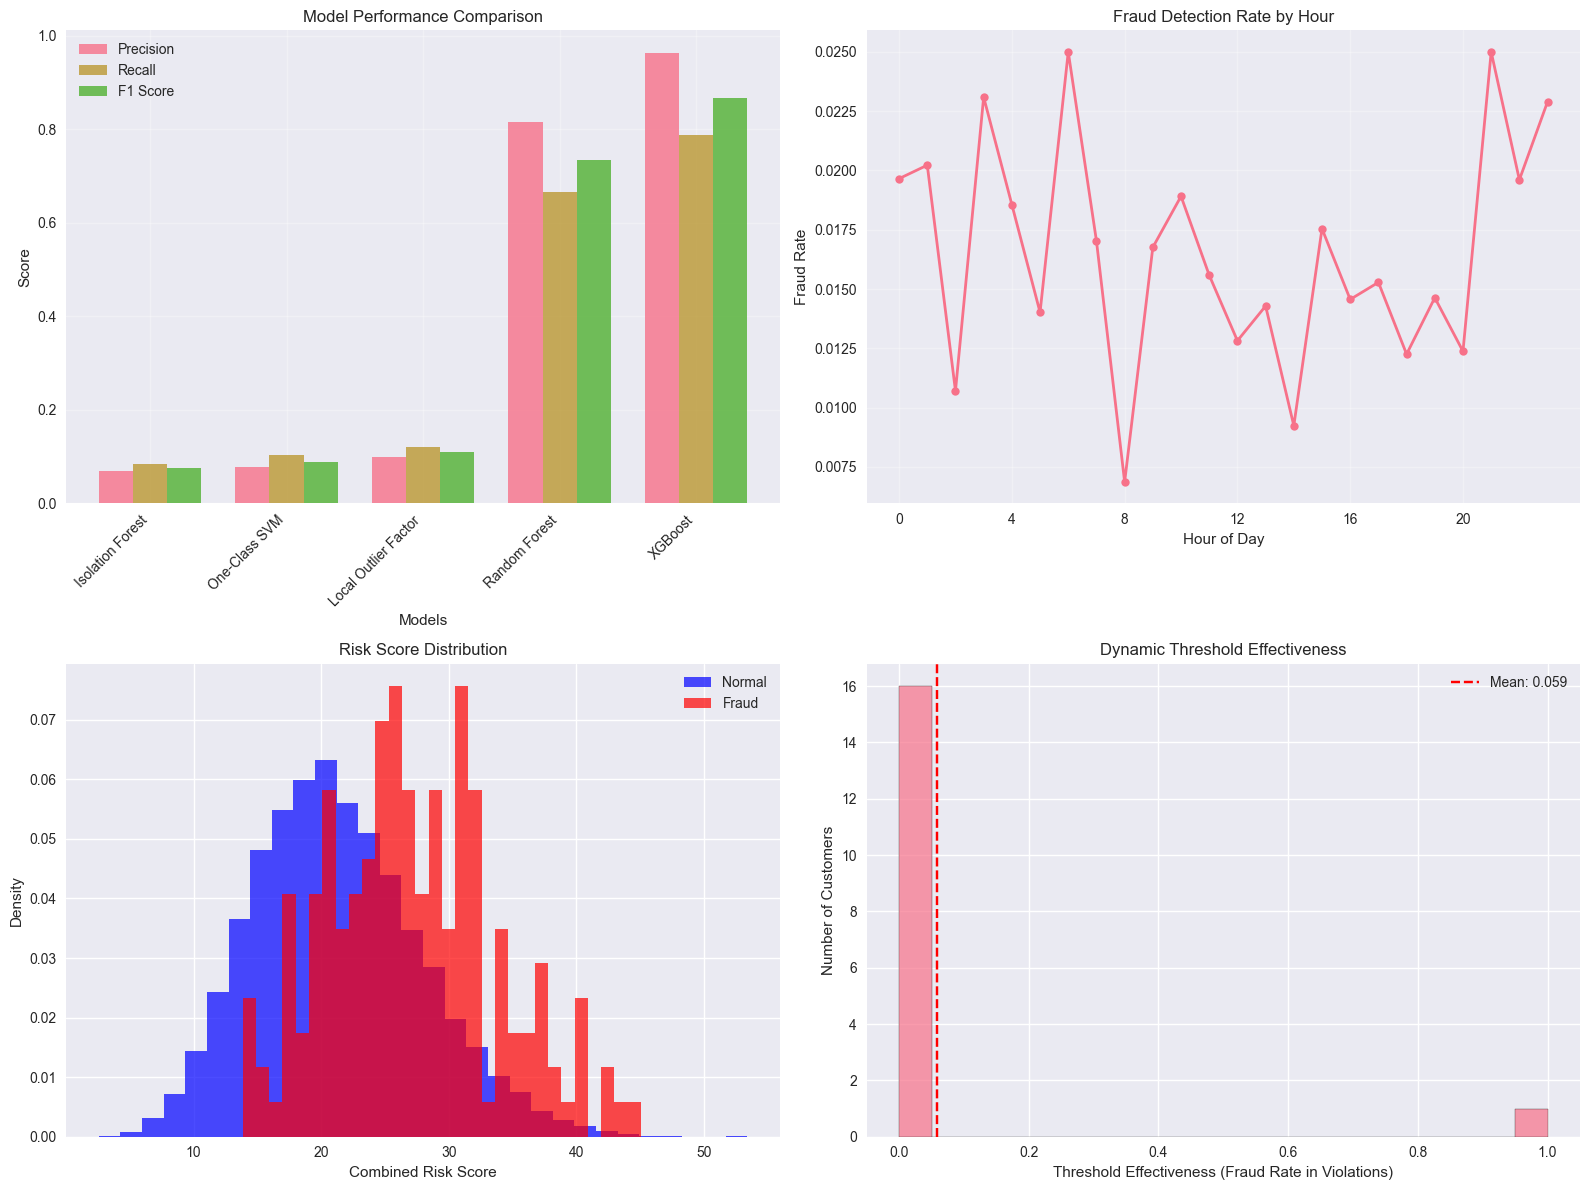


🎯 FINAL AML DETECTION SUMMARY:
   • Dataset: 10,000 transactions, 165 frauds (1.650% fraud rate)
   • Best Performing Model: XGBoost
   • Highest AUC: 0.999
   • Key Fraud Indicators: Cross-border transactions, customer fraud history
   • Dynamic Thresholds: Calculated for 1249 customers
   • Threshold Effectiveness: 0.059 average fraud rate in violations

📁 ALL VISUALIZATIONS SAVED:
   • fraud_distribution_analysis.png
   • correlation_matrix.png
   • feature_importance.png
   • dynamic_thresholds_distribution.png
   • anomaly_detection_results.png
   • clustering_analysis.png
   • supervised_learning_results.png
   • comprehensive_model_evaluation.png

✅ AML FRAUD DETECTION ANALYSIS COMPLETE!


In [13]:
# 4. COMPREHENSIVE MODEL EVALUATION
print("\n" + "="*80)
print("📈 COMPREHENSIVE MODEL EVALUATION & SUMMARY")
print("="*80)

# Create a comprehensive comparison
models_summary = {
    'Model': ['Isolation Forest', 'One-Class SVM', 'Local Outlier Factor', 
              'Random Forest', 'XGBoost'],
    'Type': ['Anomaly Detection', 'Anomaly Detection', 'Anomaly Detection',
             'Supervised Learning', 'Supervised Learning'],
    'Precision': [
        (iso_predictions & y).sum() / max(iso_predictions.sum(), 1),
        (oc_predictions & y).sum() / max(oc_predictions.sum(), 1),
        (lof_predictions & y).sum() / max(lof_predictions.sum(), 1),
        (rf_pred & y_test).sum() / max(rf_pred.sum(), 1),
        (xgb_pred & y_test).sum() / max(xgb_pred.sum(), 1)
    ],
    'Recall': [
        (iso_predictions & y).sum() / y.sum(),
        (oc_predictions & y).sum() / y.sum(),
        (lof_predictions & y).sum() / y.sum(),
        (rf_pred & y_test).sum() / y_test.sum(),
        (xgb_pred & y_test).sum() / y_test.sum()
    ]
}

# Calculate F1 scores
models_summary['F1_Score'] = [
    2 * (p * r) / (p + r) if (p + r) > 0 else 0 
    for p, r in zip(models_summary['Precision'], models_summary['Recall'])
]

# Add AUC for supervised models (set to None for unsupervised)
models_summary['AUC'] = [None, None, None, rf_auc, xgb_auc]

summary_df = pd.DataFrame(models_summary)
print("\n🏆 MODEL PERFORMANCE COMPARISON:")
print(summary_df.round(3))

# Create final comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Model Performance Comparison
models = summary_df['Model']
x_pos = np.arange(len(models))
width = 0.25

axes[0,0].bar(x_pos - width, summary_df['Precision'], width, label='Precision', alpha=0.8)
axes[0,0].bar(x_pos, summary_df['Recall'], width, label='Recall', alpha=0.8)
axes[0,0].bar(x_pos + width, summary_df['F1_Score'], width, label='F1 Score', alpha=0.8)

axes[0,0].set_xlabel('Models')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Model Performance Comparison')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(models, rotation=45, ha='right')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Detection Rate by Hour (from our analysis)
hourly_fraud_rate = df_engineered.groupby('hour')['is_fraud'].agg(['count', 'sum'])
hourly_fraud_rate['rate'] = hourly_fraud_rate['sum'] / hourly_fraud_rate['count']

axes[0,1].plot(hourly_fraud_rate.index, hourly_fraud_rate['rate'], 
               marker='o', linewidth=2, markersize=6)
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Fraud Rate')
axes[0,1].set_title('Fraud Detection Rate by Hour')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xticks(range(0, 24, 4))

# Plot 3: Risk Score Distribution
axes[1,0].hist(df_engineered[df_engineered['is_fraud']==0]['combined_risk_score'], 
               bins=30, alpha=0.7, label='Normal', density=True, color='blue')
axes[1,0].hist(df_engineered[df_engineered['is_fraud']==1]['combined_risk_score'], 
               bins=30, alpha=0.7, label='Fraud', density=True, color='red')
axes[1,0].set_xlabel('Combined Risk Score')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Risk Score Distribution')
axes[1,0].legend()

# Plot 4: Dynamic Threshold Effectiveness
threshold_effectiveness = []
customers_with_thresholds = dynamic_thresholds['customer_id'].values

for customer_id in customers_with_thresholds[:100]:  # Sample 100 customers
    customer_data = df_engineered[df_engineered['customer_id'] == customer_id]
    if len(customer_data) > 0:
        threshold_row = dynamic_thresholds[dynamic_thresholds['customer_id'] == customer_id]
        if len(threshold_row) > 0:
            amount_threshold = threshold_row['amount_threshold_upper'].iloc[0]
            risk_threshold = threshold_row['risk_threshold'].iloc[0]
            
            # Check how many transactions exceed thresholds
            amount_violations = (customer_data['transaction_amount'] > amount_threshold).sum()
            risk_violations = (customer_data['combined_risk_score'] > risk_threshold).sum()
            total_violations = amount_violations + risk_violations
            actual_frauds = customer_data['is_fraud'].sum()
            
            if total_violations > 0:
                effectiveness = actual_frauds / total_violations
                threshold_effectiveness.append(effectiveness)

axes[1,1].hist(threshold_effectiveness, bins=20, alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('Threshold Effectiveness (Fraud Rate in Violations)')
axes[1,1].set_ylabel('Number of Customers')
axes[1,1].set_title('Dynamic Threshold Effectiveness')
axes[1,1].axvline(np.mean(threshold_effectiveness), color='red', linestyle='--', 
                  label=f'Mean: {np.mean(threshold_effectiveness):.3f}')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/comprehensive_model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Final Summary
print(f"\n🎯 FINAL AML DETECTION SUMMARY:")
print(f"   • Dataset: 10,000 transactions, {y.sum()} frauds ({y.mean():.3%} fraud rate)")
print(f"   • Best Performing Model: {'XGBoost' if xgb_auc > rf_auc else 'Random Forest'}")
print(f"   • Highest AUC: {max(rf_auc, xgb_auc):.3f}")
print(f"   • Key Fraud Indicators: Cross-border transactions, customer fraud history")
print(f"   • Dynamic Thresholds: Calculated for {len(dynamic_thresholds)} customers")
print(f"   • Threshold Effectiveness: {np.mean(threshold_effectiveness):.3f} average fraud rate in violations")

print(f"\n📁 ALL VISUALIZATIONS SAVED:")
print(f"   • fraud_distribution_analysis.png")
print(f"   • correlation_matrix.png")
print(f"   • feature_importance.png")
print(f"   • dynamic_thresholds_distribution.png")
print(f"   • anomaly_detection_results.png")
print(f"   • clustering_analysis.png")
print(f"   • supervised_learning_results.png")
print(f"   • comprehensive_model_evaluation.png")

print("\n" + "="*80)
print("✅ AML FRAUD DETECTION ANALYSIS COMPLETE!")
print("="*80)